##### <img src="mioti.png" style="height: 100px">

# Challenge S5: Modelos regresivos aplicados a series temporales

## Objetivo

El objetivo de este challenge es usar nuestro dataframe de ventas en retail y hacer un modelo para la predicción de ventas para un artículo distinto del que vimos en el worksheet.

Tendréis que explorar los datos para ver el comportamiento del artículo elegido y las peculiaridades que pueda tener.

Luego tendréis que hacer un modelo que pueda predecir las ventas de este artículo usando todo lo aprendido anteriormente, probando distintos modelos, hiperparametrizándolos y por último añadiendo todas las variables sintéticas que veáis convenientes para que el modelo aprenda mejor del comportamiento de las unidades vendidas del producto.

## 1. Configuración del entorno

Cargamos los paquetes que vamos a utilizar en la sesión.

In [19]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

## 2. Carga de los datos, filtrado de nuestro artículo y visualización de los datos
 



**Carga el dataframe**

In [20]:
dataRetail = pd.read_csv('Dataframe_Retail.csv', delimiter=',')
print(dataRetail['Referencia'].unique())

['Cerveza tercio' 'Baguetes 2 unidades' 'Aceite de oliva virgen extra 5 l'
 'Bolsa naranjas 2Kg.' 'Mandarina' 'Melo  OR' 'Jamón reserva'
 'Naranja en cajas' 'Pack de plátanos'
 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)' 'Tomate jugoso al peso'
 'Filetes de salmón' 'Sepia' 'Fresa premium 500gr']


**Usa una máscara para filtrar el artículo sobre el que queremos realizar las predicciones**

In [21]:
dataSku = dataRetail[dataRetail['Referencia']=='Bolsa naranjas 2Kg.'].copy()
dataSku['Fecha'] = pd.to_datetime(dataSku['Fecha'], format='%Y-%m-%d')
dataSku=dataSku.set_index('Fecha')

<AxesSubplot:xlabel='Fecha'>

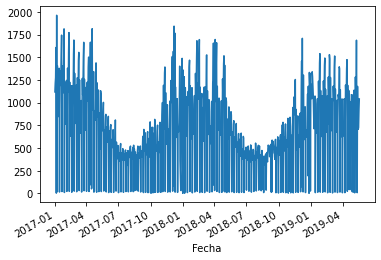

In [22]:
dataSku.loc[:,'Unidades'].plot()

** Ya que hemos cogido un producto que tiene huecos vamos a hacer una limpieza del dataframe ya que esos huecos originarían errores más tarde**

In [23]:
fechaMin = dataSku.index.min()
print(fechaMin)

2017-01-02 00:00:00


In [24]:
fechaMax = dataSku.index.max()
print(fechaMax)

2019-05-18 00:00:00


In [25]:
dateRange = pd.date_range(start=fechaMin, end=fechaMax,freq='d')
dataSku = dataSku.reindex(dateRange)
dataSku['Unidades']=dataSku['Unidades'].fillna(value=0)
dataSku['Ventas']=dataSku['Ventas'].fillna(value=0)
dataSku['Referencia']=dataSku['Referencia'].fillna(method='ffill')
dataSku=dataSku.reset_index()
dataSku=dataSku.rename(columns={'index':'Fecha Format'})
#dataSku['OffsetDays']=dataSku['OffsetDays'].astype(int)
dataSku['OffsetDays'] = dataSku.index

In [26]:
dataSku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Fecha Format  867 non-null    datetime64[ns]
 1   Referencia    867 non-null    object        
 2   Unidades      867 non-null    float64       
 3   Ventas        867 non-null    float64       
 4   OffsetDays    867 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 34.0+ KB


In [27]:
dataSku.tail(60)

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
807,2019-03-20,Bolsa naranjas 2Kg.,1068.000,1805.420060,807
808,2019-03-21,Bolsa naranjas 2Kg.,1042.000,1760.980060,808
809,2019-03-22,Bolsa naranjas 2Kg.,1394.885,2357.360079,809
810,2019-03-23,Bolsa naranjas 2Kg.,1374.000,2322.060079,810
811,2019-03-24,Bolsa naranjas 2Kg.,14.000,23.660001,811
812,2019-03-25,Bolsa naranjas 2Kg.,1143.000,1931.670065,812
813,2019-03-26,Bolsa naranjas 2Kg.,766.000,1636.200057,813
814,2019-03-27,Bolsa naranjas 2Kg.,623.000,1349.210047,814
815,2019-03-28,Bolsa naranjas 2Kg.,662.000,1435.620048,815
816,2019-03-29,Bolsa naranjas 2Kg.,948.000,2056.300070,816


In [28]:
dataSku[dataSku['Unidades']==0]

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
357,2017-12-25,Bolsa naranjas 2Kg.,0.0,0.0,357
608,2018-09-02,Bolsa naranjas 2Kg.,0.0,0.0,608
612,2018-09-06,Bolsa naranjas 2Kg.,0.0,0.0,612
622,2018-09-16,Bolsa naranjas 2Kg.,0.0,0.0,622
722,2018-12-25,Bolsa naranjas 2Kg.,0.0,0.0,722
729,2019-01-01,Bolsa naranjas 2Kg.,0.0,0.0,729
734,2019-01-06,Bolsa naranjas 2Kg.,0.0,0.0,734


<AxesSubplot:>

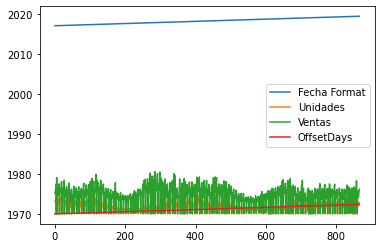

In [29]:
dataSku.plot()

## 3. Prueba de la predicción sobre nuestras unidades vendidas con distintos modelos

** Con la función de evaluación puedes probar el funcionamiento de distintos modelos**

In [30]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))
def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in range(800,866):#Modificar este data range en función de la longitud final del dataframe que nos salga
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p)
        print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sold units predicted': yPredicted,
         'Sold units actually spotted': ySpotted
        },index=xPredicted)
    prediction.plot()

** Elige el modelo que más te haya gustado o mejor haya funcionado e hiperparametrizalo si quieres**

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor

# rf = RandomForestRegressor(n_estimators=100, random_state=123)
# clf_sup = GradientBoostingRegressor(loss='quantile', alpha=0.95)
# clf_mean = GradientBoostingRegressor()
# logistic = LogisticRegression(random_state=42)
# regressor= SVR(kernel='rbf',random_state=42)
# neigh = KNeighborsRegressor(n_neighbors=2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OffsetDays  867 non-null    int64  
 1   Unidades    867 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.7 KB
Month 800 - Error 0.20150
Month 801 - Error 0.10348
Month 802 - Error 0.29768
Month 803 - Error 0.11617
Month 804 - Error 4.59799
Month 805 - Error 0.57015
Month 806 - Error 0.40205
Month 807 - Error 0.19729
Month 808 - Error 0.01537
Month 809 - Error 0.28645
Month 810 - Error 0.09050
Month 811 - Error 4.44705
Month 812 - Error 0.91009
Month 813 - Error 0.12686
Month 814 - Error 0.24827
Month 815 - Error 0.11661
Month 816 - Error 0.29778
Month 817 - Error 0.24878
Month 818 - Error 4.79227
Month 819 - Error 0.95170
Month 820 - Error 0.24528
Month 821 - Error 0.07371
Month 822 - Error 0.11213
Month 823 - Error 0.41237
Month 824 - Error 0.16820
Month 825 - Error 4.72739
Month

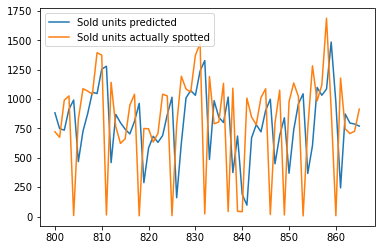

In [31]:
norma=False
dataSku_simple = dataSku[['OffsetDays','Unidades']].copy()
dataSku_simple.info()
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=20, random_state=42),dataSku_simple,norma)

In [ ]:
# Creamos una lista con los distintos modelos que queremos utilizar
# Como esta parte es sin ajustar parámetros los ejecutamos con los que vengan por defecto.
models = []
models.append(('LR',  LogisticRegression(random_state=42))) #Regresión Logística
models.append(('SVM', SVR(random_state=42)) # Máquina Vector Soporte
models.append(('GBR', GradientBoostingRegressor(random_state=42))) #GBoostingRegresor
models.append(('RFR', RandomForestRegressor(random_state=42))) #RandomForest
models.append(('KNR', KNeighborsRegressor(random_state=42))) #KNR
models.append(('MLP', MLPRegressor(random_state=42))# Red neuronal MLP

In [ ]:
df_resultados=pd.DataFrame() # Dataframe donde iremos recogiendo tanto scores, como datos de rendimiento.

for index,model in enumerate(models):
    tiempo_inicial = default_timer()
    model[1].fit(X_train, y_train)
    y_predicted = model[1].predict(X_test)
    df_resultados.loc[index,'Modelo']=model[0]
    df_resultados.loc[index,'MSE'] = mean_squared_error( y_test, y_test_hat)
    df_resultados.loc[index,'MAE'] = mean_absolute_error(   y_test, y_test_hat)
    df_resultados.loc[index,'MAD'] = median_absolute_error(  y_test, y_test_hat)
    df_resultados.loc[index,'R2'] = r2_score( y_test, y_test_hat)
    df_resultados.loc[index,'tiempo_ejecucion'] = default_timer()-tiempo_inicial # Guardamos el tiempo que ha tardado este modelo.


df_resultados


## 4. Complementar el dataframe con variables sintéticas

** En base a lo que hayas observado en el comportamiento de las unidades vendidas de tu referencia crea variables sintéticas que creas que ayuden al modelo a mejorar la predicción**